In [20]:
from __future__ import absolute_import, division

import os
import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys
from collections import Counter

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [250]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
stimuli_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import df_generation_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'df_generation_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/df_generation_helpers.pyc'>

### setup

In [372]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'stanford-cogsci.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions_recog']

# which experimental reference game dataset was used in these recognition control experiments?
exp_dict = {'refgame1.2': 'pilot3','refgame2.0':'pilot4'}
refgame_dict = {'refgame1.2': 'run3run4','refgame2.0':'run5_submitButton'}
which_experiment = 'refgame2.0'

# which iteration name should we use?
iterationName = exp_dict[which_experiment]

### get basic participation stats

In [430]:
## list of researchers
researchers = ['A4SSYO0HDVD4E', 'A1BOIDKD33QSDK','A1MMCS8S8CTWKU']
num_correct_thresh = 0
num_catch_correct_thresh = 4

## get list of valid sessions with reasonable accuracy
workers = coll.find({ '$and': [{'iterationName':iterationName}]}).distinct('workerId')
workers = [i for i in workers if len(i)>10 and i not in researchers] ## filter workers
print '{} workers performed this task'.format(len(workers))

283 workers performed this task


In [431]:
## get total number of recog events in the collection as a whole
top_workers = []
catch_passable = []
Num_correct = []
for i,w in enumerate(workers):
    print 'Analyzing {} | {} of {}'.format(w,str(i).zfill(3),len(workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
#     print w, R.count(), coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False},{'correct':1}]}).sort('time',-1).count()
    if R.count()==45:
        num_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False},{'correct':1}]}).sort('time',-1).count()
        num_catch_trial_correct = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True},{'correct':1}]}).sort('time',-1).count()    
        num_catch_trials_shown = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':True}]}).sort('time',-1).count()
        catch_passable.append(num_catch_trial_correct)
        ## make sure: (1) num correct was higher than thresh, (2) all 5 catch trials showed, 
        ## (3) catch trials were correct above threshold, and (4) it was a full session 
        if (num_correct >= num_correct_thresh) & (num_catch_trials_shown==5) & \
            (num_catch_trial_correct >= num_catch_correct_thresh): 
                top_workers.append(w)
                Num_correct.append(num_correct)
        
print '{} workers got on average {} experimental trials correct and {} catch trials correct and finished the entire HIT.'.format(len(top_workers),np.mean(Num_correct), num_catch_correct_thresh)        
print '{} workers out of {} who finished the HIT got fewer than the threshold correct.'.format(np.sum(np.array(catch_passable)<num_catch_correct_thresh), len(catch_passable))

225 workers got on average 28.8088888889 experimental trials correct and 4 catch trials correct and finished the entire HIT.
28 workers out of 253 who finished the HIT got fewer than the threshold correct.


In [375]:
# ## check how much to bonus a particular worker via compensation HIT
# reallyRun = False
# if reallyRun:
#     w = ''
#     C = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w}]}).sort('time',-1)
#     for c in C:
#         print c['score'], c['numCorrectSoFar']
#         clear_output(wait=True)

### construct group dataframe

In [432]:
## load in original refgame data to be able to look up the original trialNum
## load in run5 dataframe (no viewer timing feedback)
runName = refgame_dict[which_experiment]
O = pd.read_csv(os.path.join(csv_dir,'graphical_conventions_group_data_{}.csv'.format(runName)))
O = h.preprocess_dataframe(O)

## get total number of recog events in the collection as a whole
# grab rep & accuracy
rep = []
correct = []
rt = []
condition = []
orig_correct = []
generalization = []
target = []
distractor1 = []
distractor2 = []
distractor3 = []
orig_gameID = []
gameID = []
version = [] ## yoked vs. scrambled40 vs. scrambled 10
recog_id = []
trialNum = []
orig_trialNum = []

for i,w in enumerate(top_workers):
    print 'Now analyzing {} | {} of {}'.format(w,str(i+1).zfill(3), len(top_workers))
    clear_output(wait=True)
    R = coll.find({ '$and': [{'iterationName':iterationName}, {'workerId': w},{'catch_trial':False}]}).sort('time')
    for r in R:        
        rep.append(r['repetition'])
        correct.append(r['correct'])
        rt.append(r['rt'])
        condition.append(r['condition'])
        if 'outcome' in r.keys():
            orig_correct.append(r['outcome'])
        else:
            orig_correct.append(r['original_correct'])
        if 'Generalization' in r.keys():
            generalization.append(r['Generalization'])
        else:
            generalization.append(r['generalization'])
        target.append(r['target'])
        distractor1.append(r['distractor1'])
        distractor2.append(r['distractor2'])
        distractor3.append(r['distractor3'])
        orig_gameID.append(r['sketch'].split('_')[0])
        gameID.append(r['gameID'])
        version.append(r['version'])
        recog_id.append(r['recog_id'])
        trialNum.append(r['trialNum'])
        og = r['sketch'].split('_')[0]
        orig_trialNum.append(O[(O['gameID']==og) & \
                               (O['repetition']==r['repetition']) & \
                               (O['target']==r['target']['objectname'])]['trialNum'].values[0])
        
    
### make dataframe
X = pd.DataFrame([rep,correct,rt,condition,orig_correct,\
                 generalization,target,distractor1,distractor2,\
                 distractor3,orig_gameID,gameID,version,recog_id,trialNum,\
                 orig_trialNum])
X = X.transpose()
X.columns = ['repetition','correct','rt','condition', 'orig_correct',\
             'generalization','target','distractor1','distractor2',\
             'distractor3','orig_gameID','gameID','version','recog_id','trialNum',\
             'orig_trialNum']

## convert datatypes to numeric
X['correct'] = pd.to_numeric(X['correct'])
X['rt'] = pd.to_numeric(X['rt'])
X['orig_correct'] = pd.to_numeric(X['orig_correct'])
    
print 'Finished analyzing top workers.'
print 'There are {} observation in the dataframe.'.format(X.shape[0])

Finished analyzing top workers.
There are 9000 observation in the dataframe.


#### preprocessing helper 

In [433]:
## function to unroll target, distractor dicts into separate columns
def dict2cols(X,item='target'):
    '''
    X = dataframe containing group data
    item = which item column to unroll: target? distractor1? 
    '''
    df = pd.DataFrame.from_dict(X[item]) ## make temporary dataframe with dictionary as main column
    df2 = df[item].apply(pd.Series) ## separate into different columns
    ## rename to ensure uniqueness
    df3 = df2.rename(columns={'objectname': '{}_objectname'.format(item),\
                              'shapenetid': '{}_shapenetid'.format(item),\
                              'url': '{}_url'.format(item)})
    X2 = X.join(df3) ## add to original group dataframe
    X2.drop(labels=[item],axis=1,inplace=True) ## remove old dictionary column
    return X2

## now actually apply unrolling function
items = ['target','distractor1','distractor2','distractor3']
for item in items: 
    print 'Unrolling {}'.format(item)
    clear_output(wait=True)
    if item in X.columns:
        X = dict2cols(X,item=item)
        
print 'Finished unrolling item dictionaries into separate columns.'

Finished unrolling item dictionaries into separate columns.


In [434]:
## view recognizability by repetition in tabular form
X.groupby(['version','condition','repetition'])['correct'].mean()

version      condition  repetition
scrambled40  control    0             0.7200
                        7             0.6600
             repeated   0             0.6760
                        1             0.6880
                        2             0.6720
                        3             0.6600
                        4             0.6900
                        5             0.6940
                        6             0.7040
                        7             0.7420
yoked        control    0             0.7200
                        7             0.6900
             repeated   0             0.6825
                        1             0.7250
                        2             0.7700
                        3             0.7700
                        4             0.7725
                        5             0.7800
                        6             0.8300
                        7             0.8325
Name: correct, dtype: float64

In [435]:
## how many games from each version were finished?
X.groupby('version')['repetition'].count()/40

# X[(X['version']=='scrambled40') & (X['condition']=='repeated')].groupby('target_objectname')['repetition'].count()

version
scrambled40    125.0
yoked          100.0
Name: repetition, dtype: float64

In [436]:
## save out raw version of dataframe
X.to_csv(os.path.join(csv_dir,'graphical_conventions_recog_data_raw_{}.csv'.format(refgame_dict[which_experiment])),index=False)

### check representation of original game data in yoked/scrambled40 experiments

In [437]:
## load in dataframe
X = pd.read_csv(os.path.join(csv_dir,'graphical_conventions_recog_data_raw_{}.csv'.format(refgame_dict[which_experiment])))
# X = pd.read_csv(os.path.join(results_dir,'graphical_conventions_recog_data_raw.csv'))

In [438]:
## subset by yoked experiment 
Y = X[X['version']=='yoked']

## which orig_gameIDs got played in yoked?
orig_gameIDs_yoked = Counter(Y['orig_gameID']).keys()

## how many orig_gameIDs got played in yoked?
num_unique_orig_games = len(Counter(Y['orig_gameID']).keys())
print '{} original gameIDs appeared in the yoked experiment.'.format(num_unique_orig_games)

## how many times did each of the orig_gameIDs that did appear in yoked experiment get played?
orig_gameIDs_reps = Counter([int(i/40) for i in Counter(Y['orig_gameID']).values()])
for entry in orig_gameIDs_reps.keys():
    print '   {} were played {} times in the yoked experiment.'.format(orig_gameIDs_reps[entry],entry)

## which original gameIDs not yet represented in the yoked dataset?
## load in original group_data
path_to_group_data = os.path.join(csv_dir,'graphical_conventions_group_data_{}.csv'.format(refgame_dict[which_experiment]))
O = pd.read_csv(path_to_group_data)
orig_gameID_list = list(np.unique(O['gameID']))
orig_gameIDs_not_yet_yoked = [i for i in orig_gameID_list if i not in orig_gameIDs_yoked]
print 'There are {} original gameIDs that have not yet been played in the yoked experiment.'.format(len(orig_gameIDs_not_yet_yoked))

## save out list of gameIDs remaining in the stimuli folder, to allow these to be uploaded as their own dataset
## for targeted recruitment
if len(orig_gameIDs_not_yet_yoked)>=1:
    U = pd.DataFrame(orig_gameIDs_not_yet_yoked)
    U.columns = ['gameID']
    U.to_csv(os.path.join(stimuli_dir,'orig_gameIDs_remaining_yoked.csv'),index=False)
    print 'Saving out this list of gameIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'
else:
    print 'All original gameIDs have appeared in the yoked experiment.'

65 original gameIDs appeared in the yoked experiment.
   39 were played 1 times in the yoked experiment.
   19 were played 2 times in the yoked experiment.
   6 were played 3 times in the yoked experiment.
   1 were played 5 times in the yoked experiment.
There are 0 original gameIDs that have not yet been played in the yoked experiment.
All original gameIDs have appeared in the yoked experiment.


In [439]:
## subset by scrambled40
S = X[X['version']=='scrambled40']

## how many recog_ids got played in yoked?
num_unique_orig_recogids = len(Counter(S['recog_id']).keys())
print '{} recog_ids appeared in the scrambled40 experiment.'.format(num_unique_orig_recogids)

## which recog_ids got played in scrambled40?
recog_ids_scrambled = Counter(S['recog_id']).keys()

recog_id_reps = Counter([int(i) for i in Counter(S['recog_id']).values()])
for entry in sorted(recog_id_reps.keys()):
    print '   {} games appeared {} trials from them appear in the scrambled40 experiment.'.format(recog_id_reps[entry],entry)

## which recog_ids remaining?
recog_id_list = list(np.unique(O['recog_id']))
recog_ids_remaining = [i for i in recog_id_list if i not in recog_ids_scrambled]
grouped_recog_ids_remaining = np.unique([np.int64(i/4) for i in recog_ids_remaining])
print 'There are still {} grouped_recog_ids to run.'.format(len(grouped_recog_ids_remaining))

if len(grouped_recog_ids_remaining)>=1:
    U = pd.DataFrame(grouped_recog_ids_remaining)
    U.columns = ['grouped_recog_id']
    U.to_csv(os.path.join(stimuli_dir,'grouped_recog_ids_remaining_scrambled40.csv'),index=False)
    print 'Saving out this list of recogIDs in the stimuli folder, to allow these to be uploaded as their own dataset for targeted recruitment.'
else:
    print 'All original grouped_recog_ids have appeared in the scrambled40 experiment.'    

260 recog_ids appeared in the scrambled40 experiment.
   112 games appeared 10 trials from them appear in the scrambled40 experiment.
   84 games appeared 20 trials from them appear in the scrambled40 experiment.
   40 games appeared 30 trials from them appear in the scrambled40 experiment.
   20 games appeared 40 trials from them appear in the scrambled40 experiment.
   4 games appeared 50 trials from them appear in the scrambled40 experiment.
There are still 0 grouped_recog_ids to run.
All original grouped_recog_ids have appeared in the scrambled40 experiment.


### visualize recognizability x repetition

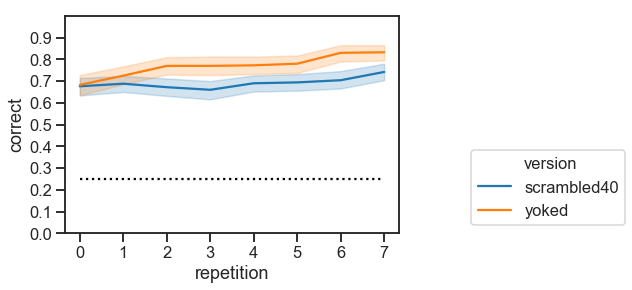

In [445]:
## get dataframe subsetted by condition and broken out by target
XR = X[X['condition']=='repeated'].reset_index(drop=True)
XR = XR.sort_values(by=['target_objectname'])
XR['repetition']=pd.to_numeric(pd.Series(XR['repetition']))
targ_list = np.unique(XR.target_objectname.values)

## convert post phase control trial repetition indices from 0-->7
XC = X[X['condition']=='control'].reset_index(drop=True)
XC['repetition'].replace(1,7,inplace=True)
XC['repetition']=pd.to_numeric(pd.Series(XC['repetition']))

## recombine to form X2
X2 = pd.concat([XR,XC],axis=0)

## plot recognizability, collapsing across target
# fig = plt.figure(figsize=(4,4))
fig, ax = plt.subplots()
sns.set_context('talk')
sns.lineplot(data=XR,x='repetition',y='correct',hue='version',ax=ax)
# sns.pointplot(data=X2_,x='repetition',y='correct',hue='version',ax=ax)
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(bbox_to_anchor=(1.7, 0), loc='lower right', ncol=1)

## plot recognizability, split out by target
split_out_by_target = False
if split_out_by_target:
    fig = plt.figure(figsize=(16,16))
    g = sns.FacetGrid(XR, col="target_objectname", col_wrap=4,height=3, margin_titles=False)
    g.map(sns.lineplot, "repetition", "correct", alpha=.7)
    g.set_titles("{col_name}")
    plt.tight_layout()

### aggregate with original refgame dataset and compare

In [446]:
## load in original group_data
O = pd.read_csv(os.path.join(csv_dir,'graphical_conventions_group_data_{}.csv'.format(runName)))
O = h.preprocess_dataframe(O)

Dataframe initially contained 65 unique games. Now contains 65 games.
There were 0 outlier games: []. Now filtered.


In [447]:
## aggregate original refgame and recog dataframes
## and add some handy additional fields
# OR = O[O['condition']=='repeated'].reset_index(drop=True)
O = O.rename(columns={'outcome':'correct'})
O['logRT'] = np.log(O['drawDuration']*1000)
O['version'] = pd.Series(['refgame']*len(O))
X2['logRT'] = np.log(X2['rt']) ## add log RT

In [448]:
## save out concatenated dataframe for stats
_O = O[['version','repetition','gameID','condition','target', 'correct', 'logRT','trialNum']]
_O = _O.assign(orig_gameID=_O['gameID']) # create column with same name as in yoked, to allow for paired-game analysis
_X2 = X2[['version','repetition','gameID','condition','target_objectname','correct', 'logRT','orig_gameID','trialNum']]
_X2.rename({'target_objectname':'target'}, axis='columns',inplace=True)
## concatenated original and recog experiments
R = pd.concat([_O,_X2],axis=0,sort=False).reset_index()
R.to_csv(os.path.join(results_dir,'graphical_conventions_recog_data.csv'),index=False)

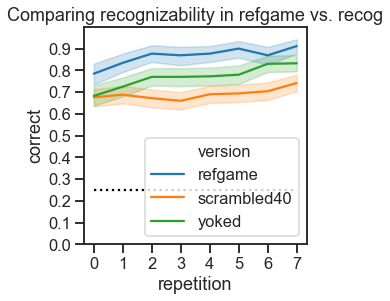

In [449]:
## plot accuracy timecourse
fig = plt.figure(figsize=(4,4))
## subset by repeated condition for this plot
_R = R[R['condition']=='repeated']
sns.lineplot(data=_R,x='repetition',y='correct',hue='version')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 8, 1))
plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing recognizability in refgame vs. recog')

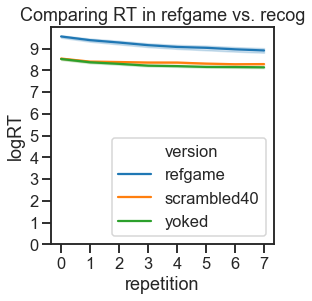

In [450]:
fig = plt.figure(figsize=(4,4))
sns.lineplot(data=_R,x='repetition',y='logRT',hue='version')
plt.ylim(0,10)
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 8, 1))
# plt.plot([0,7],[0.25,0.25],color='black',linestyle=':')
plt.legend(loc = 'lower right')
t = plt.title('Comparing RT in refgame vs. recog')

### compute BIS (z-score within new gameID)

In [451]:
def zscore(x,mu,sd):
    return (x-mu)/(sd+1e-6)

In [452]:
## sort dataframe by gameID, repetition, and target_objectname
X3 = _R.sort_values(by=['gameID','repetition','target']).reset_index(drop=True)

In [453]:
## groupby gameID
grouped = X3.groupby('gameID')

## init new aggregated vars
acc_norm = []
rt_norm = []
bis = []
gameID = []
orig_gameID = []
repetition = []
version = []
rep1_acc = []
rep1_rt = []
rep1_bis = []
trialNum = []

## loop through games
for name, group in grouped:
    print 'Analyzing {}'.format(name)
    clear_output(wait=True)
    rt_mu = group['logRT'].mean()
    rt_sd = group['logRT'].std()    
    acc_mu = group['correct'].mean()
    acc_sd = group['correct'].std()    
    
    #repwise = group.groupby('repetition')
    ## record rep1_bis
    rep1 = group[group['repetition']==0]
    rep_acc_raw = rep1['correct'].mean()
    rep_rt_raw = rep1['logRT'].mean()             
    _rep1_acc = zscore(rep_acc_raw,acc_mu,acc_sd)
    _rep1_rt = zscore(rep_rt_raw,rt_mu,rt_sd)
    _rep1_bis = _rep1_acc - _rep1_rt 
    
    ## loop through trials within games
    trialwise = group.groupby('trialNum')    
    for trialname,trial in trialwise:            
        accN = zscore(trial['correct'].values[0],acc_mu,acc_sd)
        rtN = zscore(trial['logRT'].values[0],rt_mu,rt_sd)
        acc_norm.append(accN)
        rt_norm.append(rtN)
        bis.append(accN-rtN)        
        rep1_acc.append(_rep1_acc)
        rep1_rt.append(_rep1_rt)
        rep1_bis.append(_rep1_bis)
        gameID.append(trial['gameID'].values[0])
        orig_gameID.append(trial['orig_gameID'].values[0])
        repetition.append(trial['repetition'].values[0])
        version.append(trial['version'].values[0])
        trialNum.append(trialname)

Analyzing 9938-f54b2724-decc-44d7-b42c-ecc860a647de


In [454]:
## construct summary dataframe (aggregates within repetition)
X4 = pd.DataFrame([gameID,orig_gameID,repetition,acc_norm,\
                   rt_norm,bis,rep1_bis,version,trialNum])
X4 = X4.transpose()
X4.columns = ['gameID','orig_gameID','repetition','acc_norm',\
              'rt_norm','bis','bis_baseline','version','trialNum']

## convert to numeric datatype
X4['bis']=pd.to_numeric(pd.Series(X4['bis']))
X4['bis_baseline']=pd.to_numeric(pd.Series(X4['bis_baseline']))
X4['acc_norm']=pd.to_numeric(pd.Series(X4['acc_norm']))
X4['rt_norm']=pd.to_numeric(pd.Series(X4['rt_norm']))

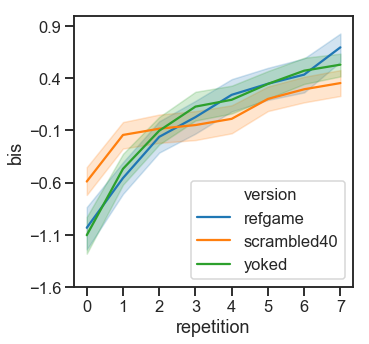

In [455]:
## visualize BIS x repetition
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition',y='bis',hue='version',ci=95)
plt.ylim(-1.5,1),
t = plt.yticks(np.arange(-1.6, 1.1, 0.5))
t = plt.xticks(np.arange(0, 8, 1))

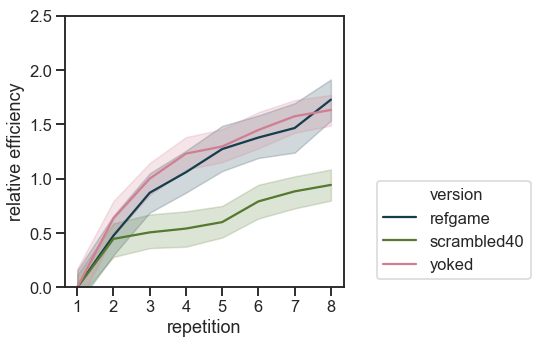

In [456]:
## baseline bis against first rep
X4['bis_relative'] = X4['bis']-X4['bis_baseline']
X4['repetition_1'] = X4['repetition'] + 1 
## save it out 
X4.to_csv(os.path.join(csv_dir,'graphical_conventions_recog_data_bis.csv'),index=False)

## plot it
colors = sns.color_palette("cubehelix", 4)[:3]
sns.set_style('white')
sns.set_style('ticks')
fig = plt.figure(figsize=(5,5))
sns.lineplot(data=X4,x='repetition_1',y='bis_relative',hue='version',palette=colors)
plt.ylim(0.,2.5)
t = plt.yticks(np.arange(0., 2.6, 0.5))
t = plt.xticks(np.arange(1, 9, 1))
plt.legend(bbox_to_anchor=(1.7, 0), loc='lower right', ncol=1)
t = plt.ylabel('relative efficiency')
t = plt.xlabel('repetition')

# out_path = os.path.join(csv_dir,'plots','recog_BIS_timeseries_seaborn.pdf')
# fig.savefig(out_path, bbox_inches='tight')

In [457]:
def rgb2hex(rgb_tuple):
    return '#%02x%02x%02x' % tuple([i*256 for i in rgb_tuple])
print 'Colors to use in ggplot are: '
print [rgb2hex(i) for i in colors]

Colors to use in ggplot are: 
['#163c4e', '#54792f', '#d07e93']


In [458]:
X4.columns

Index([u'gameID', u'orig_gameID', u'repetition', u'acc_norm', u'rt_norm',
       u'bis', u'bis_baseline', u'version', u'trialNum', u'bis_relative',
       u'repetition_1'],
      dtype='object')